In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import itertools

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": ["Helvetica"],
        "ps.usedistiller": "xpdf",
    }
)

markers = [
    "o",
    "s",
    "D",
    "^",
    "v",
    "<",
    ">",
    "p",
    "*",
    "h",
    "H",
    "+",
    "x",
    "d",
    "|",
    "_",
]
marker_cycle = itertools.cycle(markers)

def compute_u_OGM_a(K, L=1, a_val=4):
    A_val = np.zeros(K + 2)  # Pre-allocate array for A values
    alpha_val = np.zeros(K + 1)  # Pre-allocate array for alpha values
    u = np.zeros(K)  # Pre-allocate array for u values

    A_val[0] = 1
    alpha_val[0] = 1

    for ite in range(1, K + 1):
        alpha_val[ite] = (ite + a_val) / a_val
        # alpha_val[ite] = 1
        A_val[ite] = A_val[ite - 1] + alpha_val[ite]

    A_val[K + 1] = 0  # A(K+1) = 0

    for ite in range(K):
        sum_term = 0
        for j in range(ite + 1, K):
            sum_term += (
                A_val[j]
                * (1 + 2 * alpha_val[j + 1])
                * alpha_val[ite]
                * alpha_val[j + 1]
                / (2 * L * A_val[K] * (A_val[j + 1] - alpha_val[j + 1] ** 2))
            )

        u[ite] = (
            A_val[ite]
            * (1 + 2 * alpha_val[ite + 1])
            * (A_val[ite] + 2 * alpha_val[ite] * alpha_val[ite + 1])
            / (4 * L * A_val[K] * (A_val[ite + 1] - alpha_val[ite + 1] ** 2))
            + sum_term
        )

    u_sum = np.sum(u)
    tau = L / (4 * A_val[K])

    result = {
        "a": a_val,
        "A_seq": A_val.tolist(),
        "u_seq": u.tolist(),
        "u_sum": u_sum,
        "tau": tau,
        "K": K,
        "L": L,
    }
    return result

## $h(\eta) = c \eta^{-d}$

In [5]:
K_values = np.linspace(10, 1e4, num=10, dtype=int).tolist()
d_values = [1/4,1/2, 1, 2]

eta_complexity_const = np.zeros((len(K_values),len(d_values)))
eta_complexity_optimized = np.zeros((len(K_values),len(d_values)))

results = {}
for idx,K in enumerate(K_values):
    results[K]  = compute_u_OGM_a(K)
    print(f"K: {K}")
    
with open("results_b_opt.pkl", "wb") as f:
    pickle.dump(results, f)

    



K: 10
K: 1120
K: 2230
K: 3340
K: 4450
K: 5560
K: 6670
K: 7780
K: 8890
K: 10000


In [21]:


with open("results_b_opt.pkl", "rb") as f:
    results = pickle.load(f)

for K in K_values:
    result = results[K]    
    u_seq = np.array(result['u_seq'])
    A_seq = np.array(result['A_seq'])

    for idx_d,d in enumerate(d_values):
        # calculate constant inexact level b
        b_const = np.sqrt(result['tau']/result['u_sum'])
        eta_const = b_const **(-1/d)

        eta_complexity_const[K_values.index(K),d_values.index(d)] = eta_const * K

        # calculate optimized inexact levels b_i
        sum_u_pow = sum(u_seq **(1/(1+ 2* d)))
        b_optimized = 1/(2* np.sqrt(A_seq[K] * sum_u_pow)) * u_seq **(d/(1+ 2*d))
        eta_optimized = b_optimized ** (-1/d)

        eta_complexity_optimized[K_values.index(K),d_values.index(d)] = sum(eta_optimized)


    
   

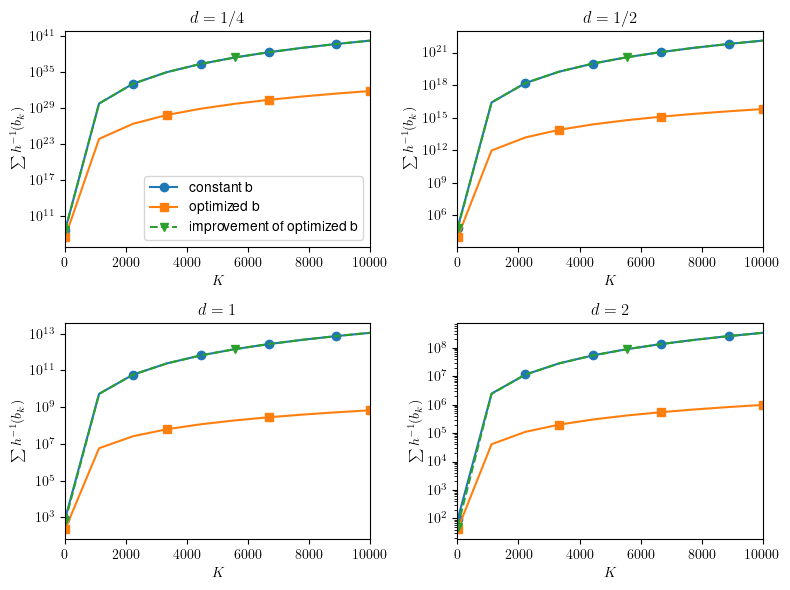

In [29]:
# plot

# plot with two scales, left y-axis for complexities, right y-axis for difference between optimized and constant
marker_cycle = itertools.cycle(markers)
fig, ax = plt.subplots(2,2,figsize = (8,6))

ax[0,0].plot(K_values,eta_complexity_const[:,0],label ='constant b',marker = 'o',markevery = 2)
ax[0,0].plot(K_values,eta_complexity_optimized[:,0],label ='optimized b',marker = 's',markevery = 3)
ax[0,0].plot(K_values,eta_complexity_const[:,0] - eta_complexity_optimized[:,0],'--',marker = 'v',markevery=5,label = 'improvement of optimized b')
ax[0,0].set_yscale('log')
ax[0,0].set_xlim(0,1e4)
# ax[0,0].set_ylim(1e50,1e)
ax[0,0].set_xlabel(r'$K$')
ax[0,0].set_ylabel(r'$\sum h^{-1}(b_k)$')
ax[0,0].legend(loc='lower right')
ax[0,0].set_title(r'$d = 1/4$')

ax[0,1].plot(K_values,eta_complexity_const[:,1],label ='constant b',marker = 'o',markevery = 2)
ax[0,1].plot(K_values,eta_complexity_optimized[:,1],label ='optimized b',marker = 's',markevery = 3)
ax[0,1].plot(K_values,eta_complexity_const[:,1] - eta_complexity_optimized[:,1],'--', marker = 'v',markevery=5,label = 'improvement of optimized b')
ax[0,1].set_yscale('log')
ax[0,1].set_xlim(0,1e4)
# ax[0,1].set_ylim(1e17,1e41)
ax[0,1].set_xlabel(r'$K$')
ax[0,1].set_ylabel(r'$\sum h^{-1}(b_k)$')
# ax[0,1].legend(loc='lower right')
ax[0,1].set_title(r'$d = 1/2$')

ax[1,0].plot(K_values,eta_complexity_const[:,2],label ='constant b',marker = 'o',markevery = 2)
ax[1,0].plot(K_values,eta_complexity_optimized[:,2],label ='optimized b',marker = 's',markevery = 3)
ax[1,0].plot(K_values,eta_complexity_const[:,2] - eta_complexity_optimized[:,2],'--',marker = 'v',markevery=5,label = 'improvement of optimized b')
ax[1,0].set_yscale('log')
ax[1,0].set_xlim(0,1e4)
# ax[1,0].set_ylim(1e8,1e23)
ax[1,0].set_xlabel(r'$K$')
ax[1,0].set_ylabel(r'$\sum h^{-1}(b_k)$')
# ax[1,0].legend(loc='lower right')
ax[1,0].set_title(r'$d = 1$')

ax[1,1].plot(K_values,eta_complexity_const[:,3],label ='constant b',marker = 'o',markevery = 2)
ax[1,1].plot(K_values,eta_complexity_optimized[:,3],label ='optimized b',marker = 's',markevery = 3)
ax[1,1].plot(K_values,eta_complexity_const[:,3] - eta_complexity_optimized[:,3],'--',marker = 'v',markevery=5,label = 'improvement of optimized b')
ax[1,1].set_yscale('log')
ax[1,1].set_xlim(0,1e4)
# ax[1,1].set_ylim(1e4,1e14)
ax[1,1].set_xlabel(r'$K$')
ax[1,1].set_ylabel(r'$\sum h^{-1}(b_k)$')
# ax[1,1].legend(loc='lower right')
ax[1,1].set_title(r'$d = 2$')
# ax[1,1].set_xticks([1000,3000,5000,7000,10000])
# ax[1,1].grid(True)

plt.tight_layout()
# plt.xticks
plt.savefig('Figures/eta_complexity_power.pdf')



## $h(\eta) = d^{-\eta}$

In [36]:
eta_complexity_const = np.zeros(len(K_values))
eta_complexity_optimized = np.zeros(len(K_values))
for K in K_values:
    result = results[K]
    A_seq = np.array(result['A_seq'])
    u_seq = np.array(result['u_seq'])
    tau = result['tau']
    L = result['L']

    b_const = np.sqrt(result['tau']/result['u_sum'])
    eta_const = -np.log(b_const)
    eta_complexity_const[K_values.index(K)] = eta_const * K

    b_optimized = np.sqrt(1/(4* K * A_seq[K] * u_seq))
    eta_optimized = -np.log(b_optimized)
    eta_complexity_optimized[K_values.index(K)] = sum(eta_optimized)


    

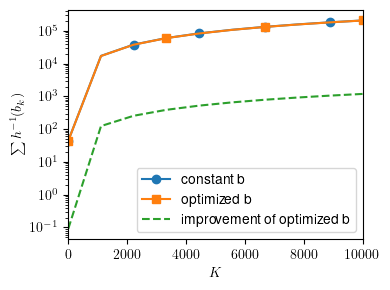

In [37]:
fig, ax = plt.subplots(1,1,figsize = (4,3))
ax.plot(K_values,eta_complexity_const,label ='constant b',marker = 'o',markevery = 2)
ax.plot(K_values,eta_complexity_optimized,label ='optimized b',marker = 's',markevery = 3)
ax.plot(K_values,eta_complexity_const - eta_complexity_optimized,'--',label = 'improvement of optimized b')
ax.set_yscale('log')
ax.set_xlim(0,1e4)
# ax.set_ylim(1e4,1e14)
ax.set_xlabel(r'$K$')
ax.set_ylabel(r'$\sum h^{-1}(b_k)$')
ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig('Figures/eta_complexity_exp.pdf')
